In [2]:
import transformers
from datasets import load_dataset
import pandas as pd
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 8

In [4]:
dataset_id = 'imdb'
dataset = load_dataset(dataset_id)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [8]:
def TextTokenizer(data):
  return tokenizer(data["text"], padding = True, truncation = True)

tokenized_dataset = dataset.map(TextTokenizer, batched = True)
tokenized_dataset

Map: 100%|████████████████████████████████████████████████████████████████████████| 50000/50000 [00:26<00:00, 1871.48 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

**Each dataset contains five features:**

text: The raw text data

label: The class label

input_ids: Dense Vector Embedding (dimension 512)

token_type_ids: Indicating sentence distinction

attention_mask: Masking tensor to ignore padding tokens during model training

In [10]:
pd.DataFrame({
    'text':tokenized_dataset['train'][:5]['text'],
    'label':tokenized_dataset['train'][:5]['label'],
    'input_ids':tokenized_dataset['train'][:5]['input_ids'],
    'token_type_ids':tokenized_dataset['train'][:5]['token_type_ids'],
    'attention_mask':tokenized_dataset['train'][:5]['attention_mask']
    })

,text,label,input_ids,token_type_ids,attention_mask
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,"[101, 1045, 12524, 1045, 2572, 8025, 1011, 375...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"[101, 1000, 1045, 2572, 8025, 1024, 3756, 1000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,If only to avoid making this type of film in t...,0,"[101, 2065, 2069, 2000, 4468, 2437, 2023, 2828...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,This film was probably inspired by Godard's Ma...,0,"[101, 2023, 2143, 2001, 2763, 4427, 2011, 2643...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Oh, brother...after hearing about this ridicul...",0,"[101, 2821, 1010, 2567, 1012, 1012, 1012, 2044...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [11]:
# Train Dataset

tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns = ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = BATCH_SIZE
)

# Test Dataset

tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    shuffle = True,
    batch_size = BATCH_SIZE
)

2025-04-02 20:53:04.294392: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
def RestructureData(data):
    '''
    This function restructures the data to a tuple ({},label).
    Tensorflow expects data to be in this particular format.
    '''
    return {'input_ids':data['input_ids'],
          'token_type_ids':data['token_type_ids'],
          'attention_mask':data['attention_mask']}, data['label']

In [14]:
# prefetch loads the next batch of data while the model is training on the current batch
# AUTOTUNE automatically adjusts the number of batches to load in the background for best performance

tf_train_dataset = tf_train_dataset.map(RestructureData).prefetch(tf.data.AUTOTUNE)
tf_val_dataset = tf_val_dataset.map(RestructureData).prefetch(tf.data.AUTOTUNE)

In [16]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[ 101, 3100, 1045, ...,    0,    0,    0],
       [ 101, 1000, 6289, ...,    0,    0,    0],
       [ 101, 2117, 2112, ...,    0,    0,    0],
       ...,
       [ 101, 2023, 2143, ..., 1037, 2265,  102],
       [ 101, 1045, 2481, ...,    0,    0,    0],
       [ 101, 1045, 2064, ..., 1996, 2143,  102]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])>}, <tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 1, 1, 0, 1, 1, 0, 1])>

2025-04-02 20:53:05.840086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


First Tensor (input_ids) shape (8, 512) which is given as (batch_size, embedding dimension)

Second Tensor (token_type_ids) shape (8, 512) which is given as (batch_size, embedding dimension)

Third Tensor (attention_mask) shape (8, 512) which is given as (batch_size, embedding dimension)

Forth Tensot (Labels) shape (8, ) (batch_size, )

In [17]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 1)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

print(batches_per_epoch, total_train_steps)

3125 9375


In [20]:
optimizer, _ = create_optimizer(init_lr = 2e-5,
                                       num_warmup_steps = 0, 
                                       num_train_steps = total_train_steps)

In [21]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = optimizer,
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    tf_train_dataset.take(1000), #sampling only the first 1000 examples from the training dataset
    validation_data = tf_val_dataset,
    epochs = 3)

Epoch 1/3
1000/1000 [==============================] - 2084s 2s/step - loss: 0.9287 - accuracy: 0.5766 - val_loss: 0.6888 - val_accuracy: 0.5002
Epoch 2/3
1000/1000 [==============================] - 2019s 2s/step - loss: 0.7391 - accuracy: 0.5595 - val_loss: 0.6857 - val_accuracy: 0.6741
Epoch 3/3
1000/1000 [==============================] - 2015s 2s/step - loss: 0.7169 - accuracy: 0.6831 - val_loss: 0.6442 - val_accuracy: 0.5643


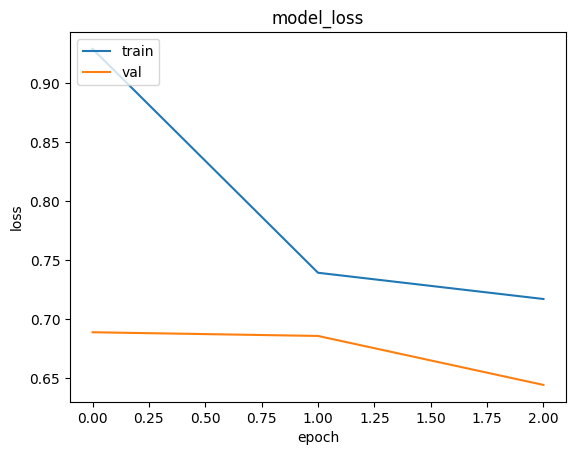

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

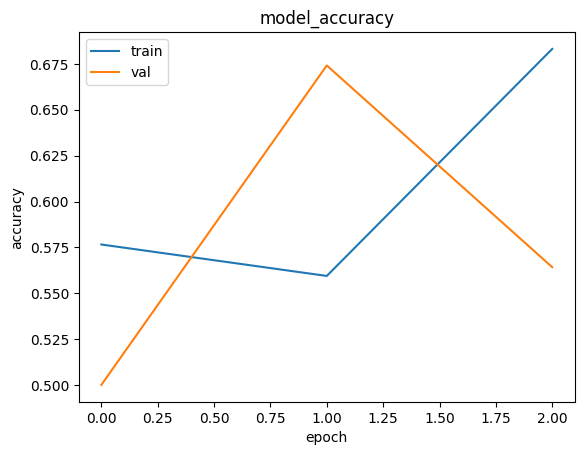

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
inputs = tokenizer(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in\
the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ","very good start, but movie started becoming \
uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards\
the middle of the movie, my favorite character got in and he did a great job, so over "],
                   padding = True,return_tensors = "tf")

logits = model(**inputs).logits
print(logits)

tf.Tensor(
[[0.50516677]
 [0.46188736]], shape=(2, 1), dtype=float32)


In [32]:
# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis = -1)

print(probabilities)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
